## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

a. Read in the dataset and take a look at the top few rows here:

In [3]:
#reading the data
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [4]:
#getting the number of rows and columns of the data frame
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
#getting the number of unique values in eacg column
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [6]:
#prortion of converted = sum of converted users / the number of users
conv = df.query('converted == 1').converted.count()
tot_conv = df.converted.count()
print(conv / tot_conv)

0.119659193556


e. The number of times the `new_page` and `treatment` don't match.

In [7]:
#Cleaning the data from misallignment for better results
new_no_trt = df[ (df['landing_page'] == 'new_page') & (df['group'] != 'treatment')].converted.shape[0]
no_new_trt = df[ (df['landing_page'] != 'new_page') & (df['group'] == 'treatment')].converted.shape[0]
print(new_no_trt + no_new_trt )

3893


f. Do any of the rows have missing values?

In [8]:
#getting the sum of null values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

In [9]:
df2 = df.query("(group == 'control' and landing_page == 'old_page') or (group == 'treatment' and landing_page == 'new_page')")

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.`

a. How many unique **user_id**s are in **df2**?

In [11]:
#getting the number of unique user ids only
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
#extracting the duplicated user id
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
#dropping the dupliated id for a clean data frame 
df2.drop([2893], inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
#re-calculating the conveted users
conv = df2.query('converted == 1').converted.shape[0]
tot_conv = df2.converted.count()
print(conv / tot_conv)

0.119597087245


b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
#calculating the conditional probability of converting control user 
conv_cont = df[ (df['group'] == 'control') & (df['converted'] == 1) ].converted.shape[0]
control = df[ (df['group'] == 'control')].converted.shape[0]
print( conv_cont / control)

0.12039917935897611


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
#calculating the conditional probability of converting treatment user 
recived = df[ (df['group'] == 'treatment') & (df['converted'] == 1) ].converted.shape[0]
trt = df[ (df['group'] == 'treatment')].converted.shape[0]
print( recived / trt)

0.11891957956489856


d. What is the probability that an individual received the new page?

In [18]:
#probability of individual received the new page = number of new page receivers / total numer of users
newpage = df[ (df['landing_page'] == 'new_page') ].converted.shape[0]
tot_rec = df.user_id.shape[0]
print(newpage / tot_rec)

0.5


e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**As seen in the results, the probability of a user changing from a page to the other is not huage, 12% from old to new and 11% from new to old. Although the trnsformation from the old to the new page is a little higher but it's not a sever different that can garnatee the effectivness of the new web page**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{old}  \geq  p_{new}$$


$$H_1: p_{old} < p_{new}$$


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new = df2[df['group'] == 'treatment'].shape[0]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = df2[df['group'] == 'control'].shape[0]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted=np.random.choice([0,1],size=n_new, p=[1-p_new,p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted=np.random.choice([0,1],size=n_old, p=[1-p_old,p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
#finding the difference between converting users of both groups
diff = new_page_converted.mean() - old_page_converted.mean()
diff

-0.00023598197394233966

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

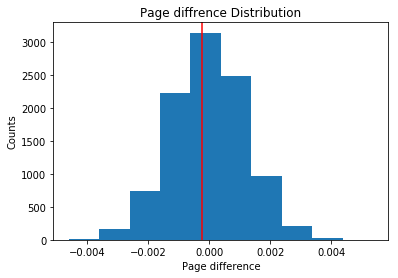

In [27]:
#plotting the histogram of the sampling distribution 
p_diffs = np.array(p_diffs, dtype=np.float32)
plt.hist(p_diffs);
plt.title('Page diffrence Distribution');
plt.xlabel('Page difference');
plt.ylabel('Counts');
plt.axvline(x= diff, color='r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
obs_diffs = df2[df2['group'] == 'treatment']['converted'].mean() -  df2[df2['group'] == 'control']['converted'].mean()
(obs_diffs < p_diffs).mean()

0.90529999999999999

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

>*We have computed the p-value of the distribution*

>The p-value ca be identifed as probablity value that can indicate the singnificance of the test results to have the evidance to either to reject or accept the null hypothesis

**Getting a low score p-value indicates that the difference between the two pages are trivial, So that, it fail to reject the null hypothesis**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm
#recalculating the p-value with a built-in function to assure our results
convert_old = df2[(df2['landing_page'] == 'old_page') & (df2['converted'] == 1)].shape[0]
convert_new = df2[ (df2['landing_page'] == 'new_page') & (df2['converted'] == 1)].shape[0]
n_old = df2[df['group'] == 'control'].shape[0]
n_new = df2[df['group'] == 'treatment'].shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [30]:
#getting the p-value and z-score 
z_score, p_value = proportions_ztest([convert_old,convert_new], [n_old, n_new], alternative='smaller')
print ("The z-score = ", z_score)
print("The p-value = " ,p_value)

The z-score =  1.31092419842
The p-value =  0.905058312759


In [31]:
from scipy.stats import norm
#getting The significance of z-score & The critical value of 95% of confidace intrvals to compare our findings
print("The significance of z-score = " , norm.cdf(z_score))
print("The critical value of 95% of confidace intrvals = ", norm.ppf(1-(0.05)))

The significance of z-score =  0.905058312759
The critical value of 95% of confidace intrvals =  1.64485362695


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The obtained p-value insues the conclusion we got frm the last step, as it validate the results and reject the fail to reject the null hypothesis. Moreover, the z-score obtained was way lower than the 95% confidance interval which als fails to reject the null hypothesis**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression model**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sb 
from patsy import dmatrices

In [33]:
#Fitting a logistic regression model 
#preparing the columns of the model
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [34]:
#preparing the independent and dependent variables
log_reg = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
#fitting the model
results = log_reg.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-14 14:22 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**There are 2 two reasons:**

**Fist:** Because  we have performed one tailed test in Part 2, and in Part 3, we are performing two tailed test.

**Second:** The privious review our null and alternative hypothesis were:

>$$H_0: p_{old}  \geq  p_{new}$$
$$H_1: p_{old} < p_{new}$$
 
But with the Logisitc regression model the null and alternative hypothesis are:

>$$H_0: p_{old}  =  p_{new}$$
$$H_1: p_{old} \neq p_{new}$$

*So the notable change in the p-value from **0.90** to **0.19** is due to the change in the null and alternative hupothesis*



f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**The inclusion of any additional variable in most of the cases is important to the analysis due to the postive and negative confounders which may make the first findings significant or trivial.**

**Cofounders are the factors that may reform the outcomes from the first variable due to thier significant effect. Postive confounders pushs the conclusion away from te null, and the negative confounder pushs the conclusion toward the null hypothesis.**

**Due to the preivious explination, adding more variables may be effective and negative. Furthermore, we always should consider the problem of *"Multicolinearity"* which can appear with adding multipe variables to the model, resulting vague and unreliable model reults**



*Reference:https://www.researchgate.net/post/Why_in_regression_analysis_the_inclusion_of_a_new_variable_makes_other_variables_that_previously_were_not_statistically_significant2*

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [36]:
#read the new data that includes a new variable "countries"
contry = pd.read_csv('countries.csv')
contry.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [37]:
#Merging the two data frames
joined_df = pd.merge(contry, df2, on='user_id')
joined_df.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [38]:
#getting unique values in oder to know nmber of needed columns for the dummy columns
joined_df["country"].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [39]:
#Fitting a logistic regression model 
#preparing the columns of the model
joined_df['intercpt'] = 1 
joined_df[['UK','US','CA']] = pd.get_dummies(joined_df['country'])
joined_df = joined_df.drop('CA', axis = 1)
joined_df.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page,intercpt,UK,US
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0,0
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,1
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,1


In [40]:
#getting more interaction columns
joined_df['US_ab_page'] = joined_df['US'] * joined_df['ab_page']
joined_df['UK_ab_page'] = joined_df['UK'] * joined_df['ab_page']
joined_df.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page,intercpt,UK,US,US_ab_page,UK_ab_page
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0,0,0,0
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,1,1,0
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,1,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
#preparing the independent and dependent variables
my_logit = sm.Logit(joined_df['converted'], joined_df[['intercept', 'ab_page', 'UK', 'US', 'US_ab_page', 'UK_ab_page']])

#fitting the model 
my_results = my_logit.fit()
my_results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-14 14:22 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
US           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
US_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
UK_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
==================================================================

"""

<a id='conclusions'></a>
## Conclusion

According to the obtained results of the lower score of p-values of each variable after countries addition, it's obvious that the new variables asscociated with *Country* has no effect on the output and it doesn't change our conclusion of rejecting the null hypothesis

**After the statistical evaluation, we can conclude that the new page had failed the test and there are no evidance supports that more poeple convert to the new page rather than the old page**

In [42]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0